In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_bin = pd.read_csv('../data/data_processed_bin.csv')
data_cat = pd.read_csv('../data/data_processed_cat.csv')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, f1_score, precision_score,recall_score,jaccard_score,roc_auc_score

from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA

import pickle
import os


In [73]:
class diseaseClassifier():
    
    def __init__(self,
                 original_bin_data,
                 original_cat_data,
                 test_size,
                 perform_pca_flag,
                 pca_treshold = None,
                 ) -> None:
        self.original_bin_data = original_bin_data
        self.original_cat_data = original_cat_data
        self.paths = {
            'main_dir' : os.getcwd(),
            'docs' : os.path.join(os.getcwd(), 'docs'),
            'figures' : os.path.join(os.getcwd(), 'docs', 'figures'),
            'models' : os.path.join(os.getcwd(), 'models'),
            'data' : os.path.join(os.getcwd(), 'data'), 
        }
        assert original_bin_data.columns.equals(original_cat_data.columns)
        self.original_data_columns = original_bin_data.columns
        self.random = False
        self.test_size = test_size
        self.perform_pca_flag = perform_pca_flag
        self.pca_treshold = pca_treshold
        self.initial_nr_of_pca_components = 90
        self.overwrite_models = True
        
        self.prepare_data()
        
        
    def prepare_data(self):
        if self.random:
            rd_state = np.random.randint(1,100)
        else:
            rd_state = 300464
            
        self.y_bin = self.original_bin_data['label']
        self.y_cat = self.original_cat_data['label']      
        
        assert self.original_bin_data.drop(columns=['label']).equals(self.original_cat_data.drop(columns=['label']))
        X = self.original_bin_data.drop(columns=['label']) 

        
        X_train, X_test, y_train, y_test = train_test_split(X, self.y_bin, test_size=self.test_size, random_state=rd_state)
        self.X_train, self.X_test = X_train, X_test
        self.data_bin = (X_train, X_test, y_train, y_test)
        X_train, X_test, y_train, y_test = train_test_split(X, self.y_cat, test_size=self.test_size, random_state=rd_state)
        assert self.X_train.equals(X_train)
        assert self.X_test.equals(X_test)
        self.data_cat = (X_train, X_test, y_train, y_test)
        
        self._scale_data(model_save=self.overwrite_models)
        
        
        if self.perform_pca_flag:
            self._perform_PCA(model_save=self.overwrite_models)

        
    def _scale_data(self, model_save = False):    
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)
        if model_save:    
            self._pickle_save(scaler, path=os.path.join(self.paths['models'], 'scaler.pkl' ))
            
    def _perform_PCA(self, model_save = False):
        nr_of_components = self.initial_nr_of_pca_components
        for n in range(1,90):
            pca = PCA(n_components=n)
            pca.fit(self.X_train)
            explained_variance = (np.sum(pca.explained_variance_ratio_))
            if explained_variance > self.pca_treshold:
                nr_of_components = n
                self.nr_of_pca_components = n
                break
            
        pca = PCA(n_components= nr_of_components)
        
        self.X_train = pca.fit_transform(self.X_train)
        self.X_test = pca.transform(self.X_test)
        if model_save:
            self._pickle_save(pca, path=os.path.join(self.paths['models'], 'pca_model.pkl' ))
      
    def _perform_training(self, model, binary):
        if binary:
            _, _, y_train, _ = self.data_bin
        model.fit(self.X_train,y_train)

        return model    
   
    
    def _pickle_save(self, object, path):
        with open(path, "wb") as file:
            pickle.dump(object, file)
            
    def _pickle_load(self, path):
        with open(path, "rb") as file:
            object = pickle.load(file)   
        return object
    
    def _roc_auc_score_multiclass(self, actual_class, pred_class, average = "macro"):
        #creating a set of all the unique classes using the actual class list
        unique_class = set(actual_class)
        roc_auc_list = []
        for per_class in unique_class:
            #creating a list of all the classes except the current class 
            other_class = [x for x in unique_class if x != per_class]

            #marking the current class as 1 and all other classes as 0
            new_actual_class = [0 if x in other_class else 1 for x in actual_class]
            new_pred_class = [0 if x in other_class else 1 for x in pred_class]

            #using the sklearn metrics method to calculate the roc_auc_score
            roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
            roc_auc_list.append(roc_auc)

        return (sum(roc_auc_list)/len(roc_auc_list)).round(decimals=2)

In [76]:
classifier = diseaseClassifier(
    original_bin_data=data_bin,
    original_cat_data=data_cat,
    test_size=0.2,
    perform_pca_flag=True,
    pca_treshold=0.95
)

print(classifier.nr_of_pca_components)

60


In [46]:
def perform_evaluation(model, test_data, data_columns, binary, average = "macro"):
    X_test, y_test = test_data
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    cm = confusion_matrix(y_test,preds)
    if binary:
        f1 = f1_score(y_test, preds)
        precision = precision_score(y_test,preds)
        recall = recall_score(y_test,preds)
        roc_auc = roc_auc_score(y_test,preds).round(decimals=2)
        mislabeled = cm[0][1] + cm[1][0]
    else:
        f1 = f1_score(y_test, preds, average=average)
        precision = precision_score(y_test,preds, average=average)
        recall = recall_score(y_test,preds, average=average)
        roc_auc = roc_auc_score_multiclass(y_test,preds, average=average)

        mislabeled = cm[0][1] + cm[0][2] + cm[1][0] + cm[2][0] + cm[2][1] + cm[1][2]

    prediction_packed = (y_test, preds)

    try:    
        features = pd.DataFrame(index=data_columns.drop('label'),data=model.feature_importances_,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)[:5]
        features['Feature'] = features.index
        features = features.values.tolist()
    except:
        features = None


    return (prediction_packed, acc, f1, precision, recall, roc_auc, cm, mislabeled), features

# def pickle_save(object, path):
#     with open(path, "wb") as file:
#         pickle.dump(object, file)
        
# def pickle_load(path):
#     with open(path, "rb") as file:
#         object = pickle.load(file)   
#     return object


# def perform_training(data, model):
#     X_train, y_train = data
#     model.fit(X_train,y_train)

#     return model

# def perform_PCA(X_train, X_test, pca_treshold, binary, initial_nr_of_components = 90, model_save = True):
#     nr_of_components = initial_nr_of_components
#     for n in range(1,90):
#         pca = PCA(n_components=n)
#         pca.fit(X_train)
        
#         explained_variance = (np.sum(pca.explained_variance_ratio_))
        
#         if explained_variance > pca_treshold:
#             nr_of_components = n
#             print(f"PCA nr_of_comp = {n}")
#             break
        
#     pca = PCA(n_components= nr_of_components)
#     if model_save:
#         if binary:
#             pickle_save(pca, "pca_model_bin.pkl")
#         else:
#             pickle_save(pca, "pca_model_cat.pkl")
    
#     return pca.fit_transform(X_train), pca.transform(X_test)

# def prepare_data(data, test_size, binary = True, random = False, pca = True):
#     if random:
#         rd_state = np.random.randint(1,100)
#     else:
#         rd_state = 300464
#     X = data.drop(columns=['label'])
#     y = data['label']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rd_state)
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     if pca:
#         X_train, X_test = perform_PCA(X_train=X_train, X_test=X_test, binary=binary, pca_treshold=0.95)

#     return (X_train, y_train), (X_test, y_test)

def check_model(model, data, test_size, data_columns, binary = True, random = False, multi_label_average = "macro"):
    train_data, test_data = prepare_data(data=data, test_size=test_size, binary=binary, random=random)
    trained_model = perform_training(train_data, model=model)
    return perform_evaluation(trained_model, test_data,data_columns, binary=binary, average=multi_label_average)

# 


def convert_metrics_to_dataframe(metrics, models_names):
    data = []
    for idx, model_metric in enumerate(metrics):
        acc = (model_metric[1])
        f1 = (model_metric[2])
        precision = (model_metric[3])
        recall = (model_metric[4])
        roc_auc = (model_metric[5])
        mislabeled = (model_metric[7])
        data.append([models_names[idx],acc,f1, precision, recall, roc_auc, mislabeled])

    columns = ["model", "Acc", "F1", "Precision", "Recall","ROC_AUC", "Mislabeled"]

    return pd.DataFrame(data=data, columns=columns)

def get_best_features(metrics, model_name):
    names = {"Random Forest" :0, "Decision Tree":1, "K-Nearest-Neighbours":2, "Logistic Regression":3, "Support Vector Classifier":4, "Ada Boost":5, "Gradient Boost":6}
    # if metrics[names[model_name]] != None:
    features = metrics[names[model_name]]
    features_names  = [n[1] for n in features]
    print(f"For model {model_name} the 5 most important features are: {features_names}")
    
def check_models(models, data, test_size, data_columns, binary = True, random = False, multi_label_average = "macro", pca = True):
    
    train_data, test_data = prepare_data(data=data, test_size=test_size, binary=binary, random=random, pca = pca)
    
    metrics = []
    features = []
    
    for model in models:
        trained_model = perform_training(train_data, model=model)
        metric, feature = perform_evaluation(trained_model, test_data,data_columns, binary=binary, average=multi_label_average)
        metrics.append(metric)
        features.append(feature)
        
    return metrics, features


### Model tuned hyperparameters for binary classification
_________________________________
RandomForestClassifier()
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}
_________________________________
DecisionTreeClassifier()
{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 2}
_________________________________
KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
_________________________________
LogisticRegression()
{'C': 1, 'l1_ratio': 0.745, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
_________________________________
SVC()
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
_________________________________
AdaBoostClassifier()
{'learning_rate': 0.1, 'n_estimators': 445}
_________________________________
GradientBoostingClassifier()
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'min_samples_split': 14, 'n_estimators': 173}
_________________________________
MLPClassifier()
{'hidden_layer_sizes': (40, 22)}


In [47]:
rf_model_bin = RandomForestClassifier(criterion= 'entropy',n_estimators=100, max_depth=6,max_features='sqrt')
dt_model_bin = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=None, min_samples_leaf=9, min_samples_split=2)
knn_model_bin = KNeighborsClassifier(algorithm='auto', leaf_size=2, n_neighbors=2, p=2, weights='uniform')
log_model_bin = LogisticRegression(solver='saga',max_iter=1000, C=1, penalty='elasticnet', l1_ratio=0.745)
svc_model_bin = SVC(kernel='rbf', C=100, gamma=0.001)
ada_model_bin = AdaBoostClassifier(n_estimators=445, learning_rate= 0.1)
gb_model_bin = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss='exponential', min_samples_split=14, n_estimators=173)
nn_model_bin = MLPClassifier(hidden_layer_sizes=(40, 22))

### Model tuned hyperparameters for multiclass classification
_________________________________
RandomForestClassifier()
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
_________________________________
DecisionTreeClassifier()
{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 2}
_________________________________
KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
_________________________________
LogisticRegression()
{'C': 1, 'l1_ratio': 0.255, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
_________________________________
SVC()
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
_________________________________
AdaBoostClassifier()
{'learning_rate': 1.0, 'n_estimators': 118}
_________________________________
GradientBoostingClassifier()
{'criterion': 'friedman_mse', 'learning_rate': 1.0, 'loss': 'log_loss', 'min_samples_split': 5, 'n_estimators': 500}
_________________________________
MLPClassifier()
{'hidden_layer_sizes': (55, 37)}

In [48]:
rf_model_cat = RandomForestClassifier(criterion= 'gini', n_estimators=200, max_depth=5,max_features='sqrt')
dt_model_cat = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=None, min_samples_leaf=9, min_samples_split=2)
knn_model_cat = KNeighborsClassifier(algorithm='auto', leaf_size=2, n_neighbors=5, p=2, weights='uniform')
log_model_cat = LogisticRegression(solver='saga',multi_class="ovr",max_iter=1000, C=1, penalty='elasticnet', l1_ratio=0.255)
svc_model_cat = SVC(kernel='rbf', C=10, gamma=0.001)
ada_model_cat = AdaBoostClassifier(n_estimators=118, learning_rate= 1)
gb_model_cat = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=1.0, loss='log_loss', min_samples_split=5, n_estimators=500)
nn_model_cat = MLPClassifier(hidden_layer_sizes=(55, 37))

In [49]:
pca_global = True
names = ["Random Forest", "Decision Tree", "K-Nearest-Neighbours", "Logistic Regression", "Support Vector Classifier", "Ada Boost", "Gradient Boost", "MultiLayerPerceptron"]

test_size = 0.2
multi_label_average_param = "weighted"

models_bin = [rf_model_bin,dt_model_bin,knn_model_bin,log_model_bin,svc_model_bin,ada_model_bin,gb_model_bin, nn_model_bin]
models_cat = [rf_model_cat,dt_model_cat,knn_model_cat,log_model_cat,svc_model_cat,ada_model_cat,gb_model_cat, nn_model_cat]

metrics_bin, features_bin = check_models(models=models_bin, data=data_bin, data_columns=data_bin.columns, test_size = test_size, pca=pca_global)
metrics_cat, features_cat = check_models(models=models_cat, data=data_cat, data_columns=data_bin.columns, test_size = test_size, binary=False, multi_label_average=multi_label_average_param, pca=pca_global)


PCA nr_of_comp = 60
PCA nr_of_comp = 60


In [50]:
if pca_global == False:    
    get_best_features(features_bin, "Random Forest")
    get_best_features(features_bin, "Decision Tree")
    get_best_features(features_bin, "Ada Boost")
    get_best_features(features_bin, "Gradient Boost")
    get_best_features(features_cat, "Random Forest")
    get_best_features(features_cat, "Decision Tree")
    get_best_features(features_cat, "Ada Boost")
    get_best_features(features_cat, "Gradient Boost")

In [32]:
results_bin = convert_metrics_to_dataframe(metrics_bin, names)
results_cat = convert_metrics_to_dataframe(metrics_cat, names)

In [33]:
results_bin.sort_values(by = "F1", ascending=False).round(decimals=3)

,model,Acc,F1,Precision,Recall,ROC_AUC,Mislabeled
4,Support Vector Classifier,1.000,1.000,1.000,1.000,1.00,0
2,K-Nearest-Neighbours,0.982,0.986,0.973,1.000,0.97,1
3,Logistic Regression,0.982,0.986,0.973,1.000,0.97,1
6,Gradient Boost,0.964,0.972,0.972,0.972,0.96,2
7,MultiLayerPerceptron,0.945,0.960,0.923,1.000,0.92,3
0,Random Forest,0.945,0.959,0.946,0.972,0.93,3
5,Ada Boost,0.945,0.959,0.946,0.972,0.93,3
1,Decision Tree,0.909,0.928,0.970,0.889,0.92,5


In [34]:
results_cat.sort_values(by = "F1", ascending=False).round(decimals=3)

,model,Acc,F1,Precision,Recall,ROC_AUC,Mislabeled
3,Logistic Regression,0.945,0.947,0.954,0.945,0.96,3
7,MultiLayerPerceptron,0.945,0.947,0.954,0.945,0.96,3
4,Support Vector Classifier,0.945,0.946,0.948,0.945,0.96,3
0,Random Forest,0.891,0.892,0.893,0.891,0.92,6
6,Gradient Boost,0.873,0.873,0.875,0.873,0.90,7
1,Decision Tree,0.855,0.856,0.858,0.855,0.89,8
2,K-Nearest-Neighbours,0.836,0.841,0.854,0.836,0.88,9
5,Ada Boost,0.836,0.832,0.865,0.836,0.88,9


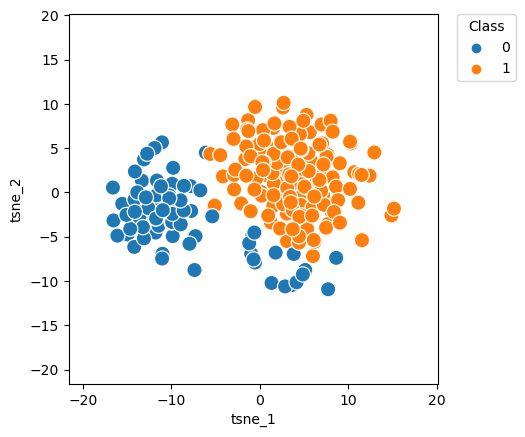

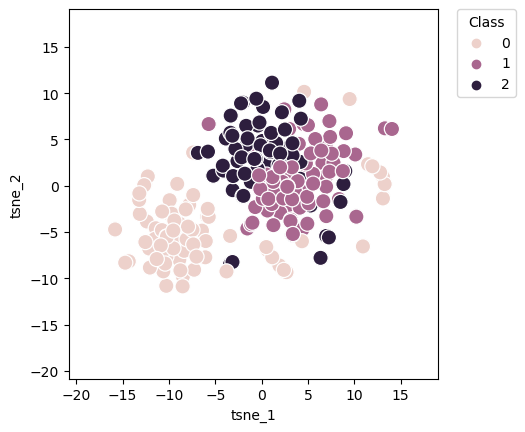

In [ ]:

def show_tsne(dataset):
    X = dataset.drop(columns=['label'])
    y = dataset['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=300464)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    from sklearn.manifold import TSNE
    y_true = y_test.copy()
    n_components = 2
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(X_train)
    tsne_result.shape
    y_true = np.reshape(y_true, (y_true.shape[0],))

    y_tsne = np.reshape(y_train, (y_train.shape[0],))
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_tsne})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, title = 'Class')
    plt.show()

for dataset in [data_bin,data_cat]:
    show_tsne(dataset)

[Text(0.625, 0.9285714285714286, 'N3 <= 0.59\ngini = 0.463\nsamples = 220\nvalue = [80, 140]'),
 Text(0.39285714285714285, 0.7857142857142857, 'C17:1 <= -0.86\ngini = 0.313\nsamples = 170\nvalue = [33, 137]'),
 Text(0.14285714285714285, 0.6428571428571429, 'TRANS <= -0.587\ngini = 0.363\nsamples = 21\nvalue = [16, 5]'),
 Text(0.07142857142857142, 0.5, 'gini = 0.0\nsamples = 11\nvalue = [11, 0]'),
 Text(0.21428571428571427, 0.5, 'C11:0 <= -0.471\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.14285714285714285, 0.35714285714285715, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.2857142857142857, 0.35714285714285715, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.6428571428571429, 0.6428571428571429, 'mean_for_age <= -0.448\ngini = 0.202\nsamples = 149\nvalue = [17, 132]'),
 Text(0.5, 0.5, 'C18:1n-7 <= 0.198\ngini = 0.337\nsamples = 14\nvalue = [11, 3]'),
 Text(0.42857142857142855, 0.35714285714285715, 'gini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(0.5714285714285714, 

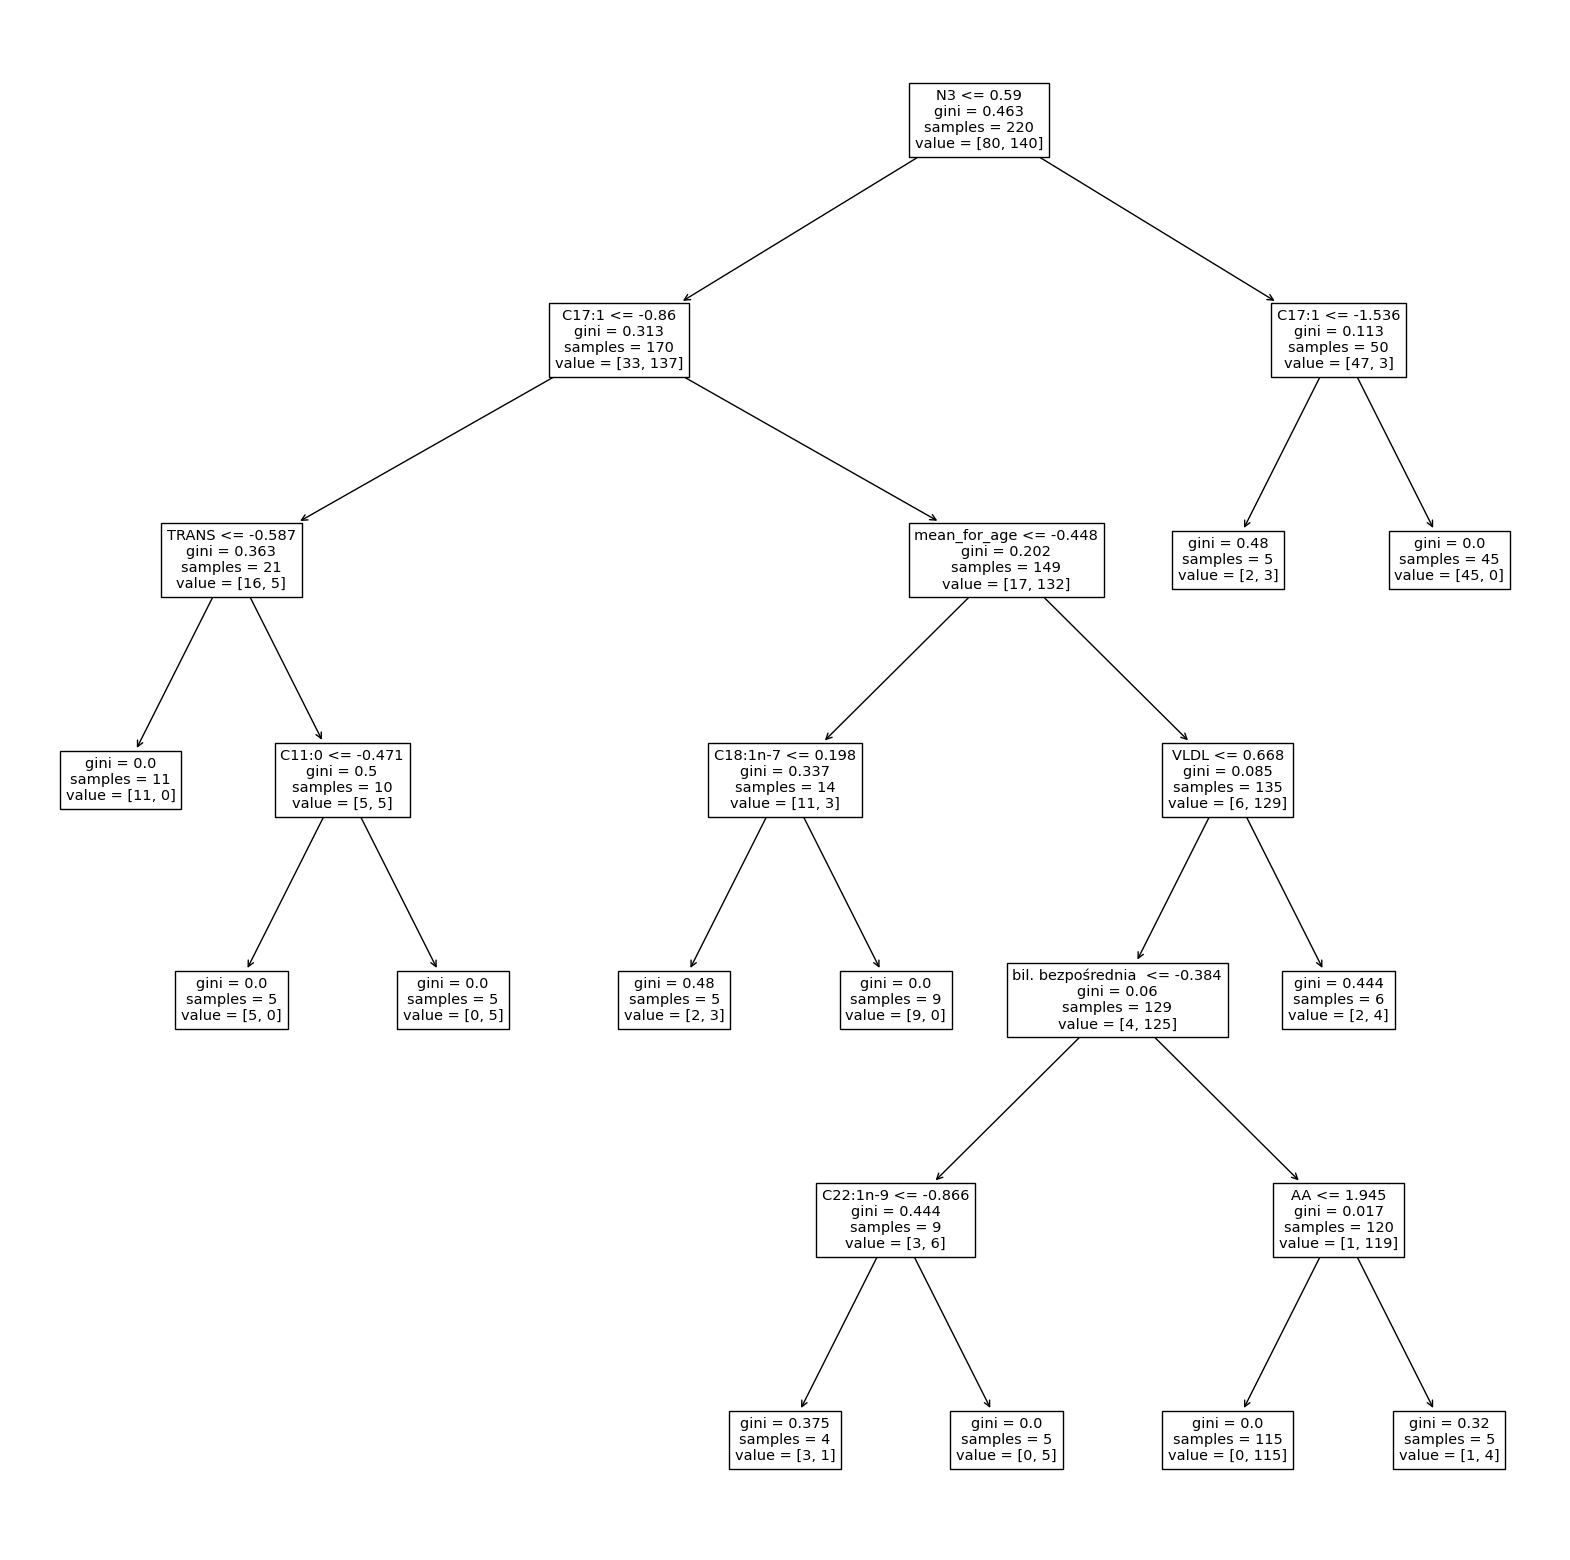

In [12]:
from sklearn import tree

plt.figure(figsize=(20,20))
tree.plot_tree(dt_model_bin,feature_names=data_bin.drop(columns=['label']).columns.values.tolist())

In [26]:
from sklearn.model_selection import GridSearchCV
from itertools import product
param_grid = [
    # { 
    # 'n_estimators': [100, 200, 500],
    # 'max_features': ['sqrt', 'log2'],
    # 'max_depth' : [4,5,6,7,8],
    # 'criterion' :['gini', 'entropy']
    # },
    # {
    # 'criterion' :['gini', 'entropy'],
    #  'max_depth' : [4,5,6,7,8, None],
    #  'min_samples_split' : np.arange(2,10),
    #  'min_samples_leaf': np.arange(1,10),
    #  'max_features': ['sqrt', 'log2', None],
    # },
    # {
    # 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    #  'leaf_size' : np.arange(2,10),
    #  'p' : [1,2],
    #  'weights' : ['uniform', 'distance'],
    #  'n_neighbors' : np.arange(2,30)
    # },
    # {
    #     'C' : [np.logspace(-3,3,9),1],
    #     'penalty' : ['l1','l2', 'elasticnet'],
    #     'max_iter' : [100,1000,5000,10000],
    #     'l1_ratio' : np.linspace(0.01,0.99,5),
    #     'solver' : ['saga']
    # },
    # {
    #     'C': [0.1,1, 10, 100],
    #     'gamma': [1,0.1,0.01,0.001],
    #     'kernel': ['rbf', 'poly', 'sigmoid']
    # },
    # {
    #     'n_estimators' : [int(n) for n in np.linspace(10,500,10)],
    #     'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0]
    # },
    # {
    #     'n_estimators' : [int(n) for n in np.linspace(10,500,10)],
    #     'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
    #     'loss' :  ['log_loss', 'exponential'],
    #     'criterion' : ['friedman_mse', 'squared_error'],
    #     'min_samples_split' : np.arange(2,15,3)
    # }
    {
        'hidden_layer_sizes' : list(list(np.arange(10, 60, 3)) + list(product(np.arange(10, 60, 3), np.arange(10, 60, 3)))),
        # 'activation' : ['identity', 'logistic', 'tanh', 'relu'],
        # 'solver' :  ['lbfgs', 'sgd', 'adam'],
        # 'alpha' : np.linspace(0.0001,0.001, 10)
    }

]
estimators=[
    # RandomForestClassifier(),
    # DecisionTreeClassifier(),
    # KNeighborsClassifier(),
    # LogisticRegression(),
    # SVC(),
    # AdaBoostClassifier(),
    # GradientBoostingClassifier()
    MLPClassifier()
]

print('#################################################3333')
print('For binary dataset:')
for dataset in [data_bin, data_cat]:

    X = dataset.drop(columns=['label'])
    y = dataset['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=300464)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    pca = PCA(n_components=60)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    for estimator, params in zip(estimators, param_grid):
        CV_rfc = GridSearchCV(estimator=estimator, param_grid=params, cv= 5)
        CV_rfc.fit(X_train, y_train)
        print('_________________________________')
        print(estimator)
        print(CV_rfc.best_params_)
    print('#################################################')
    print('For categorical dataset:')

#################################################3333
For binary dataset:


p:\Conda\envs\mgr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Convergenc

_________________________________
MLPClassifier()
{'hidden_layer_sizes': (40, 22)}
#################################################
For categorical dataset:


p:\Conda\envs\mgr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
p:\Conda\envs\mgr\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Convergenc

_________________________________
MLPClassifier()
{'hidden_layer_sizes': (55, 37)}
#################################################
For categorical dataset:


In [27]:

from itertools import product
list(list(np.arange(10, 60, 4)) + list(product(np.arange(10, 60, 15), np.arange(10, 60, 15))))

[10,
 14,
 18,
 22,
 26,
 30,
 34,
 38,
 42,
 46,
 50,
 54,
 58,
 (10, 10),
 (10, 25),
 (10, 40),
 (10, 55),
 (25, 10),
 (25, 25),
 (25, 40),
 (25, 55),
 (40, 10),
 (40, 25),
 (40, 40),
 (40, 55),
 (55, 10),
 (55, 25),
 (55, 40),
 (55, 55)]